In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
# define generator


class Generator(nn.Module):
    def __init__(self, z_dim=10, im_chan=1, hidden_dim=32):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 2, kernel_size=(6,6,5)),
            self.make_gen_block(hidden_dim * 2, hidden_dim * 2, kernel_size=(5,5,3)),
            self.make_gen_block(hidden_dim * 2, hidden_dim*4, kernel_size=(5,5,3)),
            self.make_gen_block(hidden_dim * 4, hidden_dim*2, kernel_size=(7,7,5)),
            self.make_gen_block(hidden_dim * 2, hidden_dim, kernel_size=5),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=(2,2,3), final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):

        # Build the neural block
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose3d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm3d(output_channels),
                nn.ReLU()
            )
        else: # Final Layer
            return nn.Sequential(
                nn.ConvTranspose3d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh()
            )
    def unsqueeze_noise(self, noise):
        return noise.view(len(noise), self.z_dim, 1, 1, 1)

    def forward(self, noise):
        x = self.unsqueeze_noise(noise)
        return self.gen(x)


# define hyperparameters
z_dim = 128
display_step = 5
batch_size = 2
lr = 0.001
epochs = 10
c_lambda = 10 #coefficient of gradient penalty
crit_repeats = 10

# optimizer momentum parameters
beta_1 = 0.5 
beta_2 = 0.999


In [3]:
# load gen parameters
device = torch.device('cpu')
gen = Generator(z_dim, im_chan=1, hidden_dim=16)
gen.load_state_dict(torch.load('models/gen_e6.pt', map_location=device))
gen.eval()

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): ConvTranspose3d(128, 32, kernel_size=(6, 6, 5), stride=(2, 2, 2))
      (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): ConvTranspose3d(32, 32, kernel_size=(5, 5, 3), stride=(2, 2, 2))
      (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): ConvTranspose3d(32, 64, kernel_size=(5, 5, 3), stride=(2, 2, 2))
      (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): Sequential(
      (0): ConvTranspose3d(64, 32, kernel_size=(7, 7, 5), stride=(2, 2, 2))
      (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (4): Sequential(
      (0): ConvTranspose3d(32, 16, kernel_size=(5, 5, 5), stride=(2, 2, 2))
      (1): BatchNorm3d

In [4]:
def show_scan_slices(sample_element, scan_type='', x=100, cmap='gray'):
    print("{} Scan".format(scan_type))
    plt.figure()
    f, axarr = plt.subplots(1,3) 
    plt.title("Brain Scan Slices")

    axarr[0].imshow(sample_element[x], cmap=cmap)
    axarr[0].title.set_text("Slice with fixed X")
    axarr[1].imshow(sample_element[:,x], cmap=cmap)
    axarr[1].title.set_text("Slice with fixed Y")
    axarr[2].imshow(sample_element[:,:,x], cmap=cmap)
    axarr[2].title.set_text("Slice with fixed Z")

    plt.show()

 Scan


<Figure size 432x288 with 0 Axes>

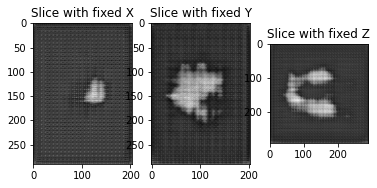

 Scan


<Figure size 432x288 with 0 Axes>

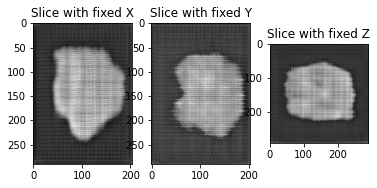

 Scan


<Figure size 432x288 with 0 Axes>

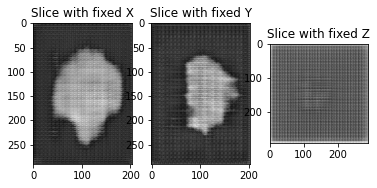

In [5]:
def get_noise(n_samples, z_dim, device, im_chan=1):
    return torch.randn(n_samples, z_dim*im_chan, device=device)

noise = get_noise(1, z_dim, device=device)
x_hat = gen(noise).detach().numpy()
show_scan_slices(x_hat[0][0], x=50)
show_scan_slices(x_hat[0][0], x=100)
show_scan_slices(x_hat[0][0], x=200)